In [104]:
import pandas as pd

train=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


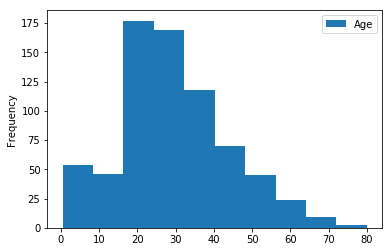

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

train.plot(kind="hist",y="Age")

In [5]:
train_copy= train.copy()

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [9]:
# Pipeline to process the numbers
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_pipeline=Pipeline([
    ('selector',DataFrameSelector(["Age","SibSp", "Parch", "Fare"])),
    ('imputer',SimpleImputer(strategy="median"))
])

num_pipeline.fit_transform(train_copy)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [10]:
# Imputer for string cat 
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)


In [12]:
from sklearn.preprocessing import OneHotEncoder

cat_pipe = Pipeline([
    ('selector',DataFrameSelector(["Pclass","Sex","Embarked"])),
    ('imputer',MostFrequentImputer()),
    ('cat_encoder',OneHotEncoder(sparse=False))
])
cat_pipe.fit_transform(train_copy)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [ ]:
# Combine the pipelines
from sklearn.pipeline import FeatureUnion

full_pipe= FeatureUnion(transformer_list=[
    ('num_pip',num_pipeline,),
    ('cat_pipeline',cat_pipe)
])

full_pipe.fit_transform(train_copy)

In [18]:
x_train=full_pipe.fit_transform(train_copy)
x_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [19]:
y_train=train_copy['Survived']

In [20]:
# First try use SGDClassfier 
from sklearn.linear_model import SGDClassifier

sgd_clf =SGDClassifier(random_state=42)

sgd_clf.fit(x_train,y_train)


c:\users\junji\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [105]:
x_test = full_pipe.transform(test_data)
y_test= sgd_clf.predict(x_test)
passenger_id= test_data.PassengerId
passenger_id

0       892
1       893
2       894
3       895
4       896
5       897
6       898
7       899
8       900
9       901
10      902
11      903
12      904
13      905
14      906
15      907
16      908
17      909
18      910
19      911
20      912
21      913
22      914
23      915
24      916
25      917
26      918
27      919
28      920
29      921
       ... 
388    1280
389    1281
390    1282
391    1283
392    1284
393    1285
394    1286
395    1287
396    1288
397    1289
398    1290
399    1291
400    1292
401    1293
402    1294
403    1295
404    1296
405    1297
406    1298
407    1299
408    1300
409    1301
410    1302
411    1303
412    1304
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [32]:
# Try our cross validation to see how good the model does 
from sklearn.model_selection import cross_val_score
sgd_cross_score = cross_val_score(sgd_clf,x_train,y_train,cv=10)
sgd_cross_score.mean()
# Thus we See that SGD Classifier does not do too well

c:\users\junji\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\junji\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\junji\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have

0.6229883100669618

## We Will use a random forest Classifier

Maybe it will do better that the sgd


In [33]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(x_train,y_train)

rf_cross_score = cross_val_score(rf_clf,x_train,y_train,cv=10)
rf_cross_score.mean(0)

c:\users\junji\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8115690614005221

In [47]:
# Use grid search to tune hyper parametest
from sklearn.model_selection import GridSearchCV
param_grid=[
    {'n_estimators':[10,20,30,40,50,60,70,80,100],'max_features': ["auto","sqrt","log2"],"warm_start":["True","False"]},
    {'bootstrap':["False"],'n_estimators':[10,15,25,35],"warm_start":["True","False"]}
]

_rf_clf= RandomForestClassifier(random_state=42)
grid_search =GridSearchCV(_rf_clf,param_grid,cv=5)
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 100], 'max_features': ['auto', 'sqrt', 'log2'], 'warm_start': ['True', 'False']}, {'bootstrap': ['False'], 'n_estimators': [10, 15, 25, 35], 'warm_start': ['True', 'False']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [48]:
grid_search.best_params_

{'max_features': 'auto', 'n_estimators': 80, 'warm_start': 'True'}

In [50]:
final_model= grid_search.best_estimator_
final_score=cross_val_score(final_model,x_train,y_train,cv=5)
final_predictions=final_model.predict(x_test)
final_score.mean()


0.8081390899383536

In [106]:
submission = pd.DataFrame({
        "PassengerId": passenger_id,
        "Survived": final_predictions
    })

submission.to_csv("submission.csv",index=False)

# Here we will use a k_neightbours_ classifier


In [109]:
from sklearn.neighbors import KNeighborsClassifier

kn_clf= KNeighborsClassifier()

kn_clf.fit(x_train,y_train)
kn_predictions= kn_clf.predict(x_test)

In [121]:
cross_val_score(kn_clf,x_train,y_train,cv=10).mean()

0.7184720803541028

## Decision Tree


In [122]:
from sklearn.tree import DecisionTreeClassifier

dt_clf= DecisionTreeClassifier(random_state=42)
cross_val_score(dt_clf,x_train,y_train,cv=10).mean()

0.7901580410850073